In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from tqdm import trange, tqdm
import time
import functools
from google.colab import drive
from google.colab import userdata
from openai import OpenAI
from google import genai
from pydantic import BaseModel, TypeAdapter

tqdm.pandas()

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_articles = pd.read_json("/content/drive/MyDrive/kb_bookings_en_20240614.json")

df_articles['article'] = df_articles['html_content'].apply(
    lambda html: BeautifulSoup(html).get_text()
)

df_articles['article'] = 'Title: ' + df_articles['title'] + '\n' + df_articles['article']
df_articles = df_articles[['article_id', 'article']]

df_articles.shape

(303, 2)

In [ ]:
df_qa = pd.read_json("/content/drive/MyDrive/bookings_train.json")

df_qa = df_qa[['question', 'article_ids']]

df_qa.shape

(150, 2)

In [ ]:
openai_client = OpenAI(api_key=userdata.get('openai_api_key'))


def get_embeddings(texts, model="text-embedding-3-small", batch_size=100):
    texts = [text.replace("\n", " ") for text in texts]
    embeddings = []
    for idx in trange(0, len(texts), batch_size):
      batch = texts[idx:idx + batch_size]
      response = openai_client.embeddings.create(input=batch, model=model).data
      embeddings += [res.embedding for res in response]
    return embeddings

In [ ]:
df_articles['article_embedding'] = get_embeddings(df_articles['article'])

100%|██████████| 4/4 [00:05<00:00,  1.48s/it]


In [ ]:
df_qa['question_embedding'] = get_embeddings(df_qa['question'])

100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


In [ ]:
def embedding_similarity(emb1, emb2):
  return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))


def rank_similar_articles(question_embedding, df, emb_col):
  sorted_indices = df[emb_col].apply(
      lambda article_emb: embedding_similarity(
          question_embedding,
          article_emb
      )
  ).argsort()

  return (
      df['article_id']
      .iloc[sorted_indices]
      .iloc[::-1]
      .tolist()
  )

In [ ]:
df_qa['pred_by_article'] = df_qa['question_embedding'].progress_apply(
    lambda q_emb: rank_similar_articles(q_emb, df_articles, 'article_embedding')
)

100%|██████████| 150/150 [00:24<00:00,  6.11it/s]


,0,1
question,How can I send my staff a link to have access ...,How can I remove the phone number field from m...
article_ids,[7cf22cc7-74d0-4829-985f-5b452059602c],[49cd4cf1-f219-4f8c-97eb-c33d8ee4262e]
question_embedding,"[-0.019442876800894737, 0.013069139793515205, ...","[-0.02094968780875206, 0.02548030950129032, -0..."
pred_by_article,"[7cf22cc7-74d0-4829-985f-5b452059602c, 66032bc...","[e0df5986-7ba4-4f05-a934-e4e701d6793c, 79010a2..."


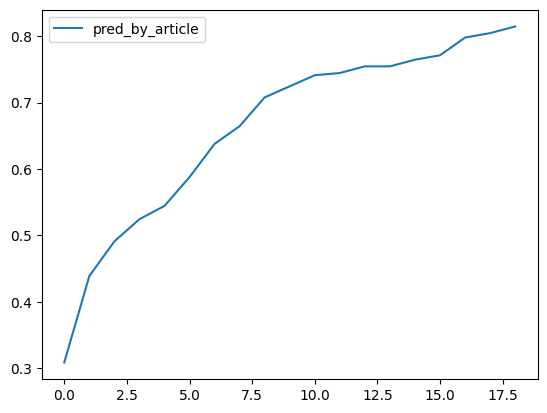

In [ ]:
def plot_recall(col_name):
  ans = []
  for k in range(1, 20):
    ans.append(
        df_qa.apply(
            lambda row: (
                len(set(row['article_ids']) & set(row[col_name][:k]))
            ) / len(row['article_ids']),
            axis=1
        ).mean()
      )
  sns.lineplot(ans, label=col_name)


plot_recall('pred_by_article')

In [ ]:
df_chunks = df_articles.assign(chunk=df_articles['article'].str.split('\n'))
df_chunks = df_chunks.explode('chunk')
df_chunks['chunk'] = df_chunks['chunk'].str.strip()
df_chunks = df_chunks[df_chunks['chunk'].map(len) > 0]
df_chunks

,article_id,article,article_embedding,chunk
0,1dd6b844-d788-48f9-aeed-5437be451bcb,Title: Wix Bookings: Scheduling Your Courses\n...,"[-0.03931708261370659, 0.013251065276563168, 0...",Title: Wix Bookings: Scheduling Your Courses
0,1dd6b844-d788-48f9-aeed-5437be451bcb,Title: Wix Bookings: Scheduling Your Courses\n...,"[-0.03931708261370659, 0.013251065276563168, 0...",Schedule your sessions exactly when you want -...
0,1dd6b844-d788-48f9-aeed-5437be451bcb,Title: Wix Bookings: Scheduling Your Courses\n...,"[-0.03931708261370659, 0.013251065276563168, 0...",Go to the Booking Calendar tab in your site's ...
0,1dd6b844-d788-48f9-aeed-5437be451bcb,Title: Wix Bookings: Scheduling Your Courses\n...,"[-0.03931708261370659, 0.013251065276563168, 0...",Course: Select the course you want to schedule...
0,1dd6b844-d788-48f9-aeed-5437be451bcb,Title: Wix Bookings: Scheduling Your Courses\n...,"[-0.03931708261370659, 0.013251065276563168, 0...",Note: Select Custom to enter a custom duration...
...,...,...,...,...
302,741cfafa-a51b-4d3c-9a81-61ee3f684046,Title: Setting Up Tax Calculation Using the Ma...,"[-0.047325726598501205, 0.009194145910441875, ...","Tax should be added at checkout: For example, ..."
302,741cfafa-a51b-4d3c-9a81-61ee3f684046,Title: Setting Up Tax Calculation Using the Ma...,"[-0.047325726598501205, 0.009194145910441875, ...",Tax is already included in my prices: For exam...
302,741cfafa-a51b-4d3c-9a81-61ee3f684046,Title: Setting Up Tax Calculation Using the Ma...,"[-0.047325726598501205, 0.009194145910441875, ...",Step 5 | (Optional) Create tax groupsNote:Tax ...
302,741cfafa-a51b-4d3c-9a81-61ee3f684046,Title: Setting Up Tax Calculation Using the Ma...,"[-0.047325726598501205, 0.009194145910441875, ...","To manage tax for an entire country, leave the..."


In [ ]:
df_chunks['chunk_embedding'] = get_embeddings(df_chunks['chunk'])

100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


In [ ]:
df_qa['pred_by_chunk'] = df_qa['question_embedding'].progress_apply(
    lambda q_emb: rank_similar_articles(q_emb, df_chunks, 'chunk_embedding')
)

100%|██████████| 150/150 [03:49<00:00,  1.53s/it]


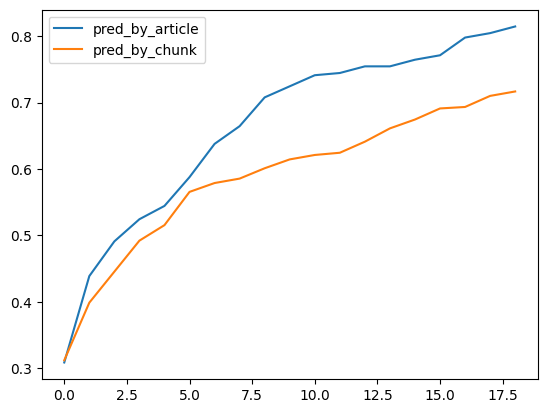

In [ ]:
plot_recall('pred_by_article')
plot_recall('pred_by_chunk')

In [ ]:
prompt_template = (
    'Following is an article from Wix Booking which is an all around '
    'scheduling product, allowing Wix users to manage their appointments, '
    'collect payment, manage staff members and many more.\n'
    '# TASK\n'
    'Please create three short and significantly different summaries about '
    'the article. Each summary should focus on a different part of the article.\n'
    '# ARTICLE\n'
    '{article}\n\n'
    '# TASK\n'
    'Please create a JSON list containing three summaries of the article. '
    'Each item in the list should be a JSON dict containing the following key:\n'
    '- "summary": a string containing a short summary of the article.'
)

print(prompt_template.format(article=df_articles.iloc[0]['article']))

Following is an article from Wix Booking which is an all around scheduling product, allowing Wix users to manage their appointments, collect payment, manage staff members and many more.
# TASK
Please create three short and significantly different summaries about the article. Each summary should focus on a different part of the article.
# ARTICLE
Title: Wix Bookings: Scheduling Your Courses
Schedule your sessions exactly when you want - whether the meetings take place at regular intervals (e.g. 1 hour per week every Monday at 8:00), or a more personalized schedule (e.g. a session of a different length once every three weeks with sessions taught by different instructors).After creating a Course, you can schedule its sessions from your booking calendar. When clients book a course, they sign up for the entire course and all its sessions. Before you begin:Create the Course service that you want to schedule (e.g. Advanced Spanish).To schedule a course session:
Go to the Booking Calendar tab 

In [ ]:
google_client = genai.Client(api_key=userdata.get('gemini_api_key'))


class Summary(BaseModel):
  summary: str


@functools.cache
def generate_summaries(article, num_retries=6, sleep_time=10):
  for _ in range(num_retries):
    try:
      prompt = prompt_template.format(article=article)
      response = google_client.models.generate_content(
          model='gemini-2.0-flash',
          contents=prompt,
          config={
              'response_mime_type': 'application/json',
              'response_schema': list[Summary],
          },
      )
      return response.parsed
    except:
      print('sleeping...')
      time.sleep(sleep_time)

In [ ]:
df_summaries = df_articles.assign(summaries=df_articles['article'].progress_apply(generate_summaries))

  6%|▌         | 17/303 [00:23<06:25,  1.35s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 11%|█         | 33/303 [01:26<05:52,  1.31s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 16%|█▌        | 49/303 [02:33<06:52,  1.63s/it]

sleeping...
sleeping...
sleeping...


 21%|██▏       | 65/303 [03:31<07:55,  2.00s/it]

sleeping...
sleeping...
sleeping...


 27%|██▋       | 81/303 [04:29<08:12,  2.22s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 32%|███▏      | 97/303 [05:41<07:56,  2.32s/it]

sleeping...
sleeping...


 37%|███▋      | 113/303 [06:30<07:05,  2.24s/it]

sleeping...
sleeping...
sleeping...


 43%|████▎     | 129/303 [07:28<04:53,  1.69s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 48%|████▊     | 145/303 [08:41<04:44,  1.80s/it]

sleeping...
sleeping...


 53%|█████▎    | 161/303 [09:39<05:24,  2.28s/it]

sleeping...
sleeping...
sleeping...


 58%|█████▊    | 177/303 [10:43<04:49,  2.30s/it]

sleeping...
sleeping...


 64%|██████▎   | 193/303 [11:40<04:11,  2.29s/it]

sleeping...
sleeping...


 69%|██████▉   | 209/303 [12:21<02:08,  1.36s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 74%|███████▍  | 225/303 [13:30<02:16,  1.76s/it]

sleeping...
sleeping...
sleeping...


 80%|███████▉  | 241/303 [14:37<02:17,  2.22s/it]

sleeping...
sleeping...
sleeping...


 85%|████████▍ | 257/303 [15:40<01:29,  1.94s/it]

sleeping...
sleeping...


 90%|█████████ | 273/303 [16:26<01:05,  2.18s/it]

sleeping...
sleeping...
sleeping...
sleeping...


 95%|█████████▌| 289/303 [17:35<00:28,  2.06s/it]

sleeping...
sleeping...
sleeping...


100%|██████████| 303/303 [18:37<00:00,  3.69s/it]


In [ ]:
df_summaries = df_summaries.explode('summaries').rename(columns={'summaries': 'summary'})
df_summaries['summary'] = df_summaries['summary'].apply(lambda summary: summary.summary)

In [ ]:
df_summaries['summary_embedding'] = get_embeddings(df_summaries['summary'])

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


In [ ]:
df_qa['pred_by_summary'] = df_qa['question_embedding'].progress_apply(
    lambda q_emb: rank_similar_articles(
        q_emb,
        pd.concat([
            df_summaries,
            df_articles.rename(columns={'article_embedding': 'summary_embedding'})
        ]),
        'summary_embedding'
    )
)

100%|██████████| 150/150 [01:29<00:00,  1.68it/s]


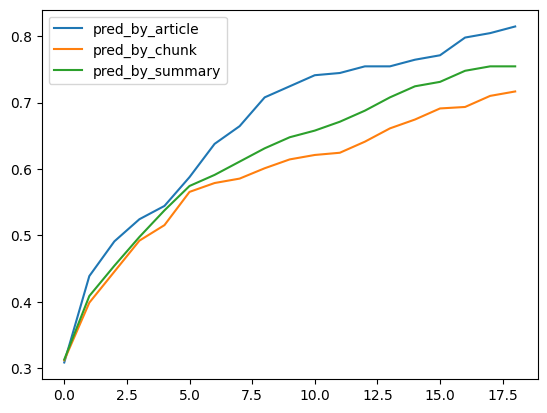

In [ ]:
plot_recall('pred_by_article')
plot_recall('pred_by_chunk')
plot_recall('pred_by_summary')